<a href="https://colab.research.google.com/github/Ronnypetson/titanic/blob/master/MNIST_Maromba.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import numpy as np
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.optim import Adam

import pandas as pd
from sklearn.metrics import accuracy_score
import matplotlib.pylab as plt
import time
from IPython import display
from IPython.core.debugger import Pdb

def breakpoint():
    Pdb().set_trace()

device = "cuda:0" if torch.cuda.is_available() else "cpu"

%matplotlib inline

### Dataset

In [ ]:
tr = ToTensor()

img_dim = 10

def _transform(x):
  x = x.resize((img_dim, img_dim))
  return (tr(x) * 2.0 - 1.0).reshape(-1)

bsize = 128

MNIST_train_data = MNIST(
    "MNIST_root/",
    download=True,
    train=True,
    transform=_transform,
)
train_data_loader = torch.utils.data.DataLoader(
    MNIST_train_data,
    batch_size=bsize,
    shuffle=True,
    num_workers=1,
)

MNIST_test_data = MNIST(
    "MNIST_root_test/",
    download=True,
    train=False,
    transform=_transform,
)
test_data_loader = torch.utils.data.DataLoader(
    MNIST_test_data,
    batch_size=bsize,
    shuffle=True,
    num_workers=1,
)

In [4]:
def _sin_arr(d, idx, rows):
  _x = (np.arange(0, d) / d) * (4 * np.pi * (1 + idx / rows))
  return np.sin(_x)

def _cos_arr(d, idx, cols):
  _x = (np.arange(0, d) / d) * (4 * np.pi * (1 + idx / cols))
  return np.cos(_x)

def _ind_arr(d, idx, bins):
  _x = np.zeros(d)
  idx = (d * idx) // bins
  _x[idx] = 1.0
  return _x

def _2ind_arr(d, idx, bins):
  return 2 * _ind_arr(d, idx, bins)

def _bincat2d(rows, cols, d=32):
  bitsr = len(format(rows, "0b"))
  bitsc = len(format(cols, "0b"))
  assert 2 * (bitsr + bitsc) <= d
  idx = np.zeros((rows, cols, d))
  for row in range(rows):
    for col in range(cols):
      binr = format(row, f"0{bitsr}b")
      binc = format(col, f"0{bitsc}b")
      for pos, bit in enumerate(binr):
        idxidx = 2 * pos + int(bit)
        idx[row, col, idxidx] = 1.0
      for pos, bit in enumerate(binc):
        idxidx = 2 * bitsr + 2 * pos + int(bit)
        idx[row, col, idxidx] = 1.0
  return idx

def _cat2d(rows, cols, d=32):
  """
  Index in the log-softmax scale.
  After sotmax (in the partition dimension)
  -inf --> 0
  1.0  --> 1
  """
  assert rows + cols <= d
  inf = 1.0
  idx = np.zeros((rows, cols, d)) - inf
  for row in range(rows):
    for col in range(cols):
      idx[row, col, row] = 1.0
      idx[row, col, rows + col] = 1.0
  idx = torch.from_numpy(idx)
  idx = idx.reshape(rows * cols, d)
  return idx

def _posenc(shape, f_row, f_col, d=32, nonlin=None):
  """
  3D Positional encodings (f_row(row) + f_col(col))
  """
  assert len(shape) == 2
  rows, cols = shape
  idx_sin = np.zeros((rows, d))
  idx_cos = np.zeros((cols, d))
  for idx in range(rows):
    idx_sin[idx] = f_row(d, idx, rows)
  for idx in range(cols):
    idx_cos[idx] = f_col(d, idx, cols)
  idx_sin = torch.from_numpy(idx_sin)
  idx_cos = torch.from_numpy(idx_cos)
  idx = (
      idx_sin.reshape((rows, 1, d)).repeat(1, cols, 1)
      + idx_cos.reshape((1, cols, d)).repeat(rows, 1, 1)
  )
  idx = idx.reshape(rows * cols, d)
  if nonlin:
    idx = nonlin(idx)
  return idx

In [ ]:
# binidx = _cat2d(5, 2, d=10)
# binidx @ binidx.T
# np.exp(binidx[0]) / np.exp(binidx[0]).sum()

In [ ]:
# rows, cols, d = 5, 5, 32
# pos = _posenc(
#     (rows, cols),
#     _ind_arr, # _sin_arr,
#     _2ind_arr, # _cos_arr,
#     d=d,
#     nonlin=lambda x: x / 3.0, # torch.sigmoid
# ).reshape(rows, cols, d)
# fig, axs = plt.subplots(nrows=rows, ncols=cols, layout=None)
# for row in range(rows):
#   for col in range(cols):
#     axs[row][col].plot(range(d), pos[row, col].numpy())
# plt.show()
# print(pos[0] @ pos[1].T)

In [5]:
# x, y = MNIST_train_data[10]
# plt.imshow(np.array(x.reshape(img_dim, img_dim))), y

### Classe Tensor Maromba

In [51]:
class MTensor:
  def __init__(
      self,
      values: torch.Tensor,
      indices: torch.Tensor,
      indexer: nn.Module=nn.Identity(),
    ):
    assert values.shape == indices.shape[:-1]
    self.data = values
    self.idx = indices
    self.idx_dim = indices.shape[-1]
    self.indexer = indexer
    self._idx_part = img_dim
    self._eps = 1e-6

  def __getitem__(self, idx):
    return MTensor(self.data[idx], self.idx[idx], self.indexer)

  def __setitem__(self, idx, value):
    self.data[idx] = value.data
    self.idx[idx] = value.idx

  def __delitem__(self, idx):
    del self.data[idx]
    del self.idx[idx]

  def __len__(self):
    return len(self.data)

  @staticmethod
  def cat(mts, dim=0):
    values = [mt.data for mt in mts]
    indices = [mt.idx for mt in mts]
    values = torch.cat(values, dim=dim)
    indices = torch.cat(indices, dim=dim)
    mt = MTensor(values, indices)
    return mt

  @staticmethod
  def unsqueeze(mt, dim=0):
    assert dim != -1
    assert dim < len(mt.idx.shape) - 1
    mt.data = mt.data.unsqueeze(dim)
    mt.idx = mt.idx.unsqueeze(dim)
    return mt

  @staticmethod
  def squeeze(mt, dim=0):
    assert dim != -1
    assert dim < len(mt.idx.shape) - 1
    mt.data = mt.data.squeeze(dim)
    mt.idx = mt.idx.squeeze(dim)
    return mt

  @staticmethod
  def clone(mt):
    return MTensor(mt.data, mt.idx, mt.indexer)

  @staticmethod
  def reshape(mt, shape):
    idx_shape = shape + (mt.idx_dim,)
    nmt = MTensor(
        mt.data.reshape(shape),
        mt.idx.reshape(idx_shape),
        mt.indexer
    )
    return nmt

  @staticmethod
  def _soft_kernel(idxu, part_dim):
    """
    idxu: M x d_u x d_idx
    """
    m, d_u, d_idx = idxu.shape
    assert d_idx % part_dim == 0
    range = 10.0
    norm_idxu = range * idxu.reshape(m, d_u, -1, part_dim) - (range / 2.0)
    norm_idxu = torch.softmax(norm_idxu, dim=-1)
    norm_idxu = norm_idxu.reshape(m, d_u, d_idx)
    return norm_idxu

  @staticmethod
  def _cosine_kernel(idxu, *args, **kwargs):
    """
    idxu: M x d_u x d_idx
    """
    norm_idxu = idxu / (torch.norm(idxu, dim=-1).unsqueeze(-1))
    return norm_idxu

  def _gbmd(self, u, v, idxu, idxv, kernel=None) -> torch.Tensor:
    """
    'General Batch Maromba Dot'
    Shorter implementation for the 'batch maromba dot' operation.
    u: M x d_u
    v: N x d_v
    idxu: M x d_u x d_idx
    idxv: N x d_v x d_idx
    """
    m, d_u = u.shape
    n, d_v = v.shape
    d_idx = idxu.shape[-1]
    assert (m, d_u, d_idx) == idxu.shape
    assert (n, d_v, d_idx) == idxv.shape
    if kernel:
      idxu = kernel(idxu, self._idx_part)
      idxv = kernel(idxv, self._idx_part)
    # uidxu: M x d_idx
    # vidxv: N x d_idx
    uidxu = torch.bmm(u.reshape(m, 1, d_u), idxu).squeeze(1)
    vidxv = torch.bmm(v.reshape(n, 1, d_v), idxv).squeeze(1)
    dot = uidxu @ vidxv.T
    ### Under experimentation
    normalizer = idxu.sum(dim=1) @ idxv.sum(dim=1).T
    # dot = dot / normalizer
    ###
    return dot

  def _kernel_idx(self, idxu, idxv, k):
    """
    k: callable: A x B x C -> A x B x C
    idxu: M x d_u x d_idx
    idxv: N x d_v x d_idx
    """
    m, d_u, d_idx = idxu.shape
    n, d_v, _ = idxv.shape
    assert d_idx == idxv.shape[-1]
    # kidxu: M x d_u x d_idx
    # kidxv: N x d_v x d_idx
    kidxu = k(idxu, self._idx_part)
    kidxv = k(idxv, self._idx_part)
    assert kidxu.shape == idxu.shape
    assert kidxv.shape == idxv.shape
    # ski: (M * N) x d_idx
    # skj: (M * N) x d_idx
    # norm: M x N x 1
    ski = kidxu.sum(dim=1)
    skj = kidxv.sum(dim=1)
    norm = (ski @ skj.T).unsqueeze(-1)
    ski = ski.unsqueeze(1).repeat(1, n, 1).reshape(m * n, d_idx, 1)
    skj = skj.unsqueeze(1).repeat(m, 1, 1).reshape(m * n, d_idx, 1)
    # idxu, kidxu: (M * d_u) x d_idx x 1
    # idxv, kidxv: (N * d_v) x d_idx x 1
    idxu = idxu.reshape(m * d_u, d_idx, 1)
    idxv = idxv.reshape(n * d_v, d_idx, 1)
    kidxu = kidxu.reshape(m * d_u, d_idx, 1)
    kidxv = kidxv.reshape(n * d_v, d_idx, 1)
    # sikiT: M x d_idx x d_idx
    # sjkjT: N x d_idx x d_idx
    sikiT = torch.bmm(idxu, kidxu.permute(0, 2, 1))
    sikiT = sikiT.reshape(m, d_u, d_idx, d_idx).sum(dim=1)
    sjkjT = torch.bmm(idxv, kidxv.permute(0, 2, 1))
    sjkjT = sjkjT.reshape(n, d_v, d_idx, d_idx).sum(dim=1)
    # sikiT: (M * N) x d_idx x d_idx
    # sjkjT: (M * N) x d_idx x d_idx
    sikiT = sikiT.unsqueeze(1).repeat(1, n, 1, 1).reshape(m * n, d_idx, d_idx)
    sjkjT = sjkjT.unsqueeze(0).repeat(m, 1, 1, 1).reshape(m * n, d_idx, d_idx)
    # diag_sikiT_skjjT: (M * N) x d_idx
    skjjT = sjkjT.permute(0, 2, 1)
    diag_sikiT_skjjT = torch.diagonal(torch.bmm(sikiT, skjjT), dim1=1, dim2=2)
    diag_sikiT_skjjT = diag_sikiT_skjjT.unsqueeze(-1)
    # xor_idx = torch.bmm(sikiT, skj) + torch.bmm(sjkjT, ski)
    # xor_idx = torch.bmm(sikiT, skj) + torch.bmm(sjkjT, ski) - diag_sikiT_skjjT
    xor_idx = diag_sikiT_skjjT
    xor_idx = xor_idx.reshape(m, n, d_idx)
    xor_idx = xor_idx / norm
    return xor_idx

  def __matmul__(self, b):
    """
    Useful for computing m-product between a batch of inputs (N x ...) and a
    parameter matrix (m x n).

    self.data: pre_shape(self) x in_dim(self)
    self.data.idx: pre_shape(self) x in_dim(self) x d_idx
    b.data: pre_shape(b) x in_dim(b)
    b.idx: pre_shape(b) x in_dim(b) x d_idx

    Returns 'mdot'
    mdot.data: pre_shape(self) x pre_shape(b)
    mdot.idx: pre_shape(self) x pre_shape(b) x d_idx
    """
    apre = self.data.shape[:-1]
    bpre = b.data.shape[:-1]
    d_idx = self.idx.shape[-1]
    assert d_idx == b.idx.shape[-1]
    aidx = self.idx.reshape(*((-1,) + self.idx.shape[-2:]))
    bidx = b.idx.reshape(*((-1,) + b.idx.shape[-2:]))
    mdot = self._gbmd(
        self.data.reshape(-1, self.data.shape[-1]),
        b.data.reshape(-1, b.data.shape[-1]),
        aidx,
        bidx,
        kernel=MTensor._soft_kernel
        # kernel=MTensor._cosine_kernel
    )
    mdot = mdot.reshape(apre + bpre)
    midx = self._kernel_idx(
        aidx,
        bidx,
        MTensor._soft_kernel
        # MTensor._cosine_kernel
    )
    midx = midx.reshape(apre + bpre + (d_idx,))
    mdot = MTensor(mdot, midx, self.indexer)
    return mdot

  def __mul__(self, b):
    """
    self: N x out_a x in_a (x d_idx)
    b:    N x out_b x in_b (x d_idx)
    """
    n, out_a, in_a = self.data.shape
    assert b.data.shape[0] == n
    _, out_b, in_b = b.data.shape
    d_idx = self.idx.shape[-1]
    assert b.idx.shape[-1] == d_idx
    # adata = self.data.reshape(n * out_a, in_a).unsqueeze(1)
    # aidx = self.idx.reshape(n * out_a, in_a, d_idx)
    # bdata = b.data.reshape(n * out_b, in_b).unsqueeze(1)
    # bidx = b.idx.reshape(n * out_b, in_b, d_idx)
    # # aidxa: N x out_a x d_idx
    # # bidxb: N x out_b x d_idx
    # aidxa = torch.bmm(adata, aidx).squeeze(1).reshape(n, out_a, d_idx)
    # bidxb = torch.bmm(bdata, bidx).squeeze(1).reshape(n, out_b, d_idx)
    # # dot: N x out_a x out_b
    # dot = torch.bmm(aidxa, bidxb.permute(0, 2, 1))
    # # idx = self._xor_idx(aidx, bidx)
    # return dot
    ### Solução provisória. Calcular o índice com paralelismo ainda não é possível.
    mdots = [MTensor.unsqueeze(self[idx] @ b[idx], dim=0) for idx in range(n)]
    mdots = MTensor.cat(mdots, dim=0)
    return mdots

### Classe do Módulo Treinável

In [7]:
class MModule(nn.Module):
  def __init__(self, n_params=600, idx_dim=32, samples=32, sets=64, device="cpu"):
    super().__init__()
    self.idx_dim = idx_dim
    self.samples = samples
    self.sets = sets
    self.device = device
    self.n_params = n_params
    ### TODO: checar inicialização de W
    self.W = nn.Parameter(torch.randn((1, n_params), device=device))
    _W_idx = torch.rand((1, n_params, idx_dim), device=device)
    # _W_idx = 2.0 * _W_idx - 1.0
    # _W_idx = nn.functional.relu(_W_idx)
    # _W_idx = _W_idx / _W_idx.max()
    self.W_idx = nn.Parameter(_W_idx)
    self.MW = MTensor(self.W, self.W_idx)
    self.activation = nn.ReLU()
    # self.activation = nn.Tanh() # nn.Sigmoid()

  def _msample(self, x: MTensor, n_sets, n_samples):
    """
    x.data: N x in_dim
    x.idx: N x in_dim x idx_dim

    Returns
    x_sets: N x n_sets x n_samples
    """
    n, in_dim, idx_dim = x.idx.shape
    assert x.data.shape == (n, in_dim)
    x_sets = []
    for _ in range(n_sets):
      idx = np.random.choice(in_dim, n_samples, replace=False)
      idx = torch.tensor(idx).long()
      # x_sampled.data: N x 1 x n_samples
      x_sampled = MTensor.unsqueeze(x[:, idx], dim=1)
      x_sets.append(x_sampled)
    # x_sets.data: N x n_sets x n_samples
    x_sets = MTensor.cat(x_sets, dim=1)
    return x_sets

  def _W_step(
      self,
      x: MTensor,
      W: MTensor,
      sets,
      samples,
      random=True,
      activation=True):
    """
    x.data: N x in_dim
    x.idx: N x in_dim x idx_dim
    """
    n, in_dim, idx_dim = x.idx.shape
    assert x.data.shape == (n, in_dim)
    # Put 1 into x
    one = MTensor(
        torch.ones(n, 1).to(self.device),
        torch.ones(n, 1, idx_dim).to(self.device),
    )
    x = MTensor.cat([x, one], dim=1)
    # Sample W
    # W_sets = []
    # for _ in range(self.sets):
    #   idx = np.random.choice(self.n_params, self.samples, replace=False)
    #   idx = torch.tensor(idx).long()
    #   W_sets.append(self.MW[:, idx])
    # W_sets = MTensor.cat(W_sets, dim=0)
    # W_sets = self._msample(self.MW, self.sets, self.samples)
    if random:
      W_sets = self._msample(W, sets, samples)
      W_sets = MTensor.squeeze(W_sets, 0)
    else:
      W_sets = MTensor.reshape(W, (sets, samples))
    # mdot: N x sets
    mdot = x @ W_sets
    if activation:
      mdot.data = self.activation(mdot.data)
    return mdot

  def _pool_step(self, x: MTensor, sets, samples, activation=True):
    """
    x.data: N x in_dim
    x.idx: N x in_dim x idx_dim
    """
    n, in_dim, idx_dim = x.idx.shape
    assert x.data.shape == (n, in_dim)
    # x0: N x 1 x samples
    # x1: N x sets x samples
    x0 = self._msample(x, 1, samples)
    x1 = self._msample(x, sets, samples)
    # mdot.data: N x sets
    mdot = x0 * x1
    mdot = MTensor.squeeze(mdot, 1)
    if activation:
      mdot.data = self.activation(mdot.data)
    return mdot

  def _forward(self, x: MTensor, n_steps=2):
    """
    x.data: N x in_dim
    x.idx: N x in_dim x idx_dim
    """
    assert n_steps > 0
    # pool: N x sets
    activate = (n_steps > 1)
    pool = self._W_step(x, activation=activate)
    for step in range(1, n_steps):
      # pool: N x (in_dim + step * sets)
      activate = (step < n_steps - 1)
      if step % 2 == 0:
        pool_new = self._pool_step(pool, activation=activate)
      else:
        pool_new = self._W_step(pool, activation=activate)
      pool = MTensor.cat([pool, pool_new], dim=1)
    return pool_new
  
  def forward(self, x: MTensor):
    """
    x.data: N x in_dim
    x.idx: N x in_dim x idx_dim
    """
    n_sets, n_samples = len(self.sets), len(self.samples)
    assert n_sets == n_samples
    assert n_sets > 0
    pool = x
    # Pdb().set_trace()
    wl, wr = 0, self.sets[0] * self.samples[0]
    for step in range(n_sets):
      activate = (step < n_sets - 1)
      pool = self._W_step(
          pool,
          self.MW[:, wl: wr],
          self.sets[step],
          self.samples[step],
          random=False,
          activation=activate
      )
      nxt_step = (step + 1) % n_sets
      next_wr = wr + self.sets[nxt_step] * self.samples[nxt_step]
      wl, wr = wr, next_wr
    return pool

### Função de Custo

In [57]:
from sklearn.metrics import accuracy_score

def _check_shapes(y_true, y_pred, true_index, pred_index):
  n, d_out = y_true.shape
  assert y_true.shape[0] == y_pred.shape[0]
  assert true_index.shape[0] == pred_index.shape[0]
  assert true_index.shape[-1] == pred_index.shape[-1]

def _maromba_loss(y_true, y_pred, true_index, pred_index):
  """
  y_true: N x d_out(true)
  y_pred: N x d_out(pred)
  true_index: N x d_out(true) x d_index
  pred_index: N x d_out(pred) x d_index
  """
  _check_shapes(y_true, y_pred, true_index, pred_index)
  # index_match: N x d_out(pred) x d_out(true)
  ###
  pred_index = MTensor._soft_kernel(pred_index, img_dim)
  # pred_index = MTensor._cosine_kernel(pred_index)
  ###
  index_match = torch.bmm(pred_index, true_index.permute(0, 2, 1))
  ### Under experimentation
  # index_match = nn.functional.softmax(index_match, dim=-1)
  ###
  # y_true_match: N x 1 x d_out(pred)
  # y_pred_match: N x 1 x d_out(true)
  y_pred_match = torch.bmm(y_pred.unsqueeze(1), index_match)
  y_true_match = torch.bmm(y_true.unsqueeze(1), index_match.permute(0, 2, 1))
  # huber = nn.HuberLoss()
  # match_loss_lr = huber(y_pred, y_true_match.squeeze(1))
  # match_loss_rl = huber(y_true, y_pred_match.squeeze(1))
  # loss = match_loss_lr + match_loss_rl
  ce = nn.CrossEntropyLoss() # nn.NLLLoss() #
  loss_lr = ce(y_pred_match.squeeze(1), torch.argmax(y_true, dim=-1))
  # loss_rl = ce(y_true_match.squeeze(1), torch.argmax(y_pred, dim=-1))
  loss_rl = ce(y_pred, torch.argmax(y_true_match.squeeze(1), dim=-1))
  loss = loss_lr + loss_rl
  return loss

def _pool2category(y_true, y_pred, true_index, pred_index):
  _check_shapes(y_true, y_pred, true_index, pred_index)
  # index_match: N x d_out(pred) x d_out(true)
  index_match = torch.bmm(pred_index, true_index.permute(0, 2, 1))
  y_pred_match = torch.bmm(y_pred.unsqueeze(1), index_match)
  y_pred_match = torch.argmax(y_pred_match.squeeze(1), dim=-1).tolist()
  return y_pred_match

def _maromba_accuracy(y_true, y_pred, true_index, pred_index):
  ###
  # pred_index = MTensor._cosine_kernel(pred_index)
  pred_index = MTensor._soft_kernel(pred_index, img_dim)
  ###
  y_pred_match = _pool2category(y_true, y_pred, true_index, pred_index)
  y_true = torch.argmax(y_true, dim=-1).tolist()
  acc = accuracy_score(y_true, y_pred_match)
  return acc

def maromba_accuracy(y_true, y_pred):
  return _maromba_accuracy(y_true.data, y_pred.data, y_true.idx, y_pred.idx)

def maromba_loss(y_true, y_pred):
  return _maromba_loss(y_true.data, y_pred.data, y_true.idx, y_pred.idx)

### Treino

In [52]:
num_classes = 10
rows, cols = img_dim, img_dim
hidden_dim = img_dim
clf_dim = (1 + (num_classes - 1) // img_dim) * img_dim
idx_dim = rows + cols + hidden_dim + clf_dim

# template_x_idx = _posenc(
#     (rows, cols),
#     _ind_arr,
#     _2ind_arr,
#     d=idx_dim,
#     nonlin=lambda x: x / 3.0,
# )
template_x_idx = _cat2d(rows, cols, d=idx_dim)
template_x_idx = template_x_idx.unsqueeze(0).float().to(device)
template_y_idx = torch.eye(idx_dim)[-num_classes:]
template_y_idx = template_y_idx.float().unsqueeze(0).to(device)

def prepare_input(x, y, device="cpu"):
  n = x.shape[0]
  x_idx = template_x_idx.repeat(n, 1, 1)
  yoh = torch.zeros(n, num_classes)
  yoh[range(n), y] = 1.0
  yoh = yoh.to(device)
  y_idx = template_y_idx.repeat(n, 1, 1)
  x = MTensor(x, x_idx)
  y = MTensor(yoh, y_idx)
  return x, y

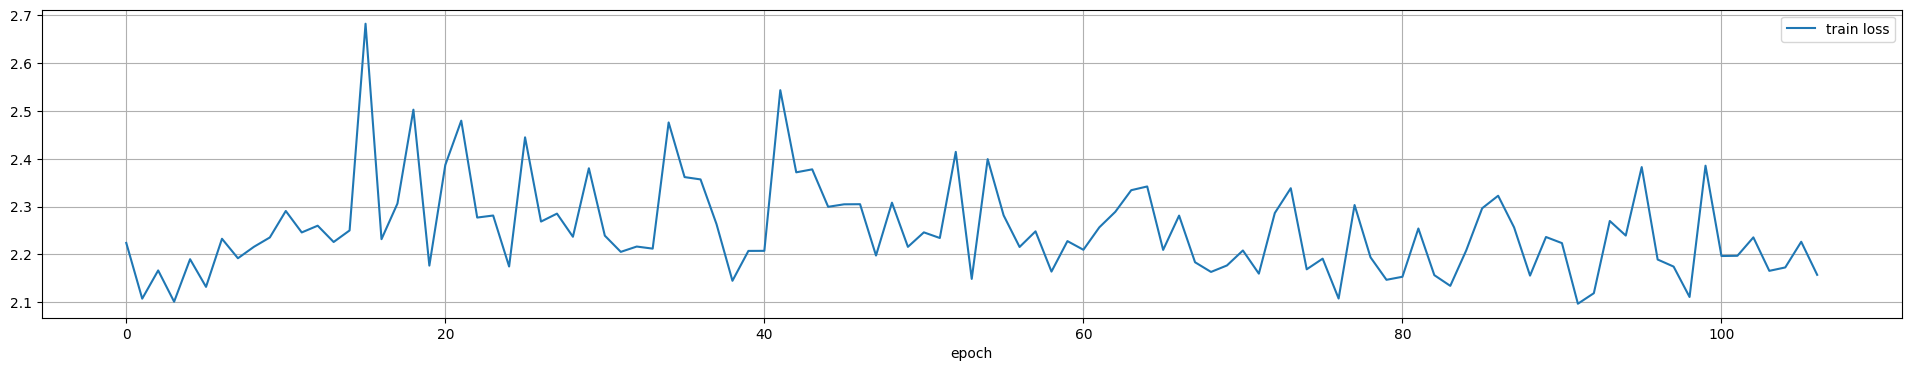

In [ ]:
hidden_dim = 400
# model = MModule(
#     n_params=rows * cols * hidden_dim + hidden_dim * num_classes,
#     idx_dim=idx_dim,
#     samples=[rows * cols, hidden_dim],
#     sets=[hidden_dim, num_classes],
#     device=device
# )
# optimizer = Adam(model.parameters(), lr=1e-3) # 1e-2

num_epochs = 720 * 4
epoch_len = 60 # len(MNIST_train_data) // bsize

train_log = {
    "train loss": [],
    "eval loss": [],
    "acc": [],
    "set": [],
    "epoch": [],
}
for epoch in range(num_epochs):
  model.train()
  train_iter = iter(train_data_loader)
  for _ in range(epoch_len):
    x, y = next(train_iter)
    x = x.to(device)
    y = y.to(device)
    x, y = prepare_input(x, y, device=device)
    y_pred = model.forward(x)
    optimizer.zero_grad()
    loss = maromba_loss(y, y_pred)
    loss.backward()
    optimizer.step()
    train_log["train loss"].append(loss.item())
    train_log["eval loss"].append(np.nan)
    train_log["acc"].append(np.nan)
    train_log["set"].append("train")
    train_log["epoch"].append(epoch)
  if False:
    model.eval()
    for x, y in iter(test_data_loader):
      x = x.to(device)
      y = y.to(device)
      x, y = prepare_input(x, y, device=device)
      y_pred = model.forward(x)
      loss = maromba_loss(y, y_pred)
      acc = maromba_accuracy(y, y_pred)
      train_log["eval loss"].append(loss.item())
      train_log["train loss"].append(np.nan)
      train_log["acc"].append(acc.item())
      train_log["set"].append("eval")
      train_log["epoch"].append(epoch)
    group_cols = ["epoch", "train loss", "eval loss", "acc"]
  else:
    group_cols = ["epoch", "train loss"]
  df_train = pd.DataFrame(train_log)
  display.clear_output(wait=True)
  (
    df_train[group_cols]
    .groupby("epoch")
    .agg(lambda x: x.median(skipna=True))
    .plot(figsize=(24, 4), grid=True)
  )
  plt.show()

In [ ]:
while True:
  pass

In [ ]:
pd.DataFrame(train_log)

In [42]:
# y_pred.idx = nn.functional.softmax(y_pred.idx, dim=-1)
y_pred.idx = MTensor._soft_kernel(y_pred.idx, img_dim)

index_match = torch.bmm(y_pred.idx, y.idx.permute(0, 2, 1))
# index_match = nn.functional.softmax(index_match, dim=-1)
# y_true_match: N x 1 x d_out(pred)
# y_pred_match: N x 1 x d_out(true)
y_pred_match = torch.bmm(y_pred.data.unsqueeze(1), index_match)

In [45]:
# y_pred_match[0]
# index_match[6]
# MTensor._soft_kernel(y_pred.idx, img_dim)[0][:, -img_dim:]
# y_pred.idx[0]
# y_pred.data[0: 5]
# [param.grad.max() for param in model.parameters()]

In [22]:
# soft_W_idx = MTensor._soft_kernel(model.MW.idx, img_dim)
soft_W_idx = MTensor._cosine_kernel(model.MW.idx, img_dim)
# torch.argmax(soft_W_idx[0].reshape(-1, img_dim), dim=-1).reshape(-1, 3)[:10]

In [ ]:
# model.MW.idx[0, 0]
MTensor._soft_kernel(model.MW.idx, img_dim)[0, 3]

tensor([1.3913e-12, 7.4956e-11, 1.0000e+00, 2.4445e-12, 1.8093e-12, 1.1454e-08,
        3.4748e-09, 1.0000e+00, 6.5183e-14, 1.0942e-11, 7.1707e-11, 1.5431e-08,
        7.4792e-06, 1.1855e-07, 1.2084e-03, 9.6670e-01, 3.2081e-02, 2.8714e-06],
       device='cuda:0', grad_fn=<SelectBackward0>)

In [ ]:
y_pred.idx[0]

### Visualização dos índices dos parâmetros

In [23]:
soft_W_idx = soft_W_idx.cpu().detach().numpy()[0]

In [28]:
from sklearn.manifold import TSNE

sample_idx = np.random.choice(len(soft_W_idx), 1000)

W_idx_tsne = TSNE(
    n_components=2,
    perplexity=30,
).fit_transform(soft_W_idx[sample_idx])

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='W_idx x tsne', ylabel='W_idx y tsne'>

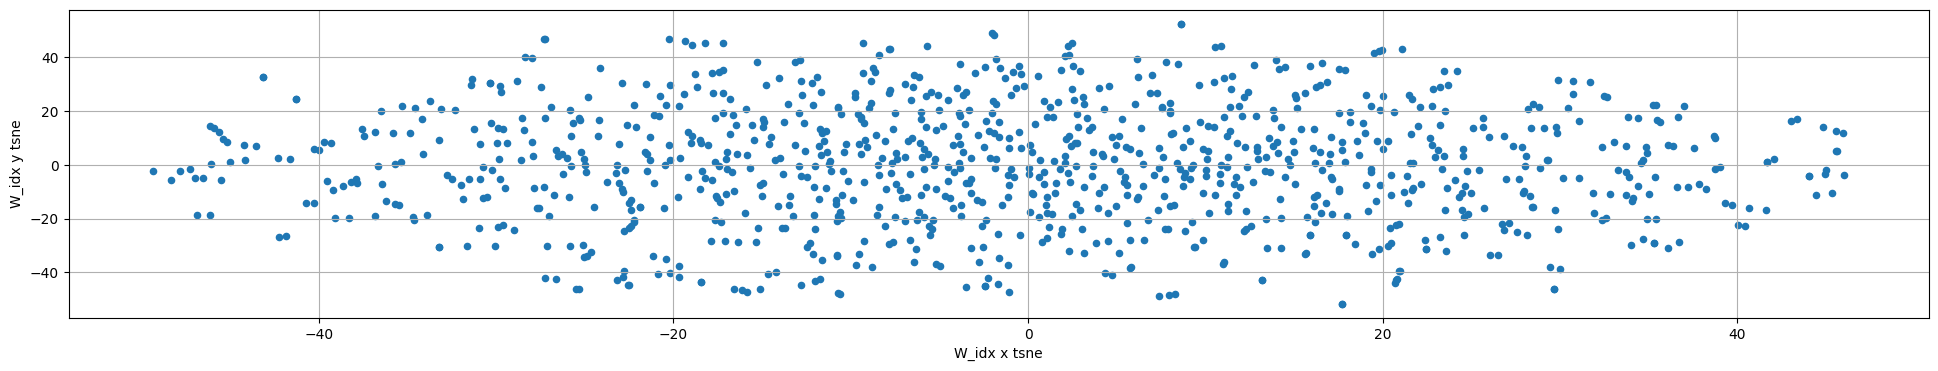

In [29]:
plot_df = pd.DataFrame(
    {
        "W_idx x tsne": W_idx_tsne[:, 0],
        "W_idx y tsne": W_idx_tsne[:, 1],
    }
)

plot_df.plot.scatter(
    x="W_idx x tsne",
    y="W_idx y tsne",
    figsize=(24, 4),
    grid=True
)